## `animation_hadgem-LL-ssp85.ipynb`: create animation for SSP5-85 scenario for hadgem-ll model

In [3]:
import context
import warnings
import intake
import xarray as xr 
import matplotlib.pyplot as plt 
import pandas as pd
import cftime
import gcsfs
import cartopy.crs as ccrs
from pathlib import Path
import pandas as pd
from a448_lib import data_read
import fsspec
import cmocean as cm
import cartopy.feature as cfeature
import numpy as np
import warnings
import matplotlib.animation as animation
import matplotlib.path as mpath

found this_dir=PosixPath('/home/jovyan/work/data_share')
found lib_dir=PosixPath('/home/jovyan/work/data_share/a448_lib')
******************************
context imported. Front of path:
/home/jovyan/work/data_share
back of path: /home/jovyan/.ipython
******************************



### Grab json file with all of the data from cmip6

* Download the catalog in csv and json format

In [4]:
csv_filename = "pangeo-cmip6.csv"
root = "https://storage.googleapis.com/cmip6"
if Path(csv_filename).is_file():
    print(f"found {csv_filename}")
else:
    print(f"downloading {csv_filename}")
    data_read.download(csv_filename,root=root)
    
json_filename="https://storage.googleapis.com/cmip6/pangeo-cmip6.json"

found pangeo-cmip6.csv


* make a dataframe from the csv version

In [5]:
catalog_df=pd.read_csv(csv_filename)
catalog_df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tauv,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ta,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


* make an intake collection from the json version

In [6]:
col = intake.open_esm_datastore(json_filename)

In [7]:
col

,unique
activity_id,17
institution_id,36
source_id,86
experiment_id,168
member_id,650
table_id,37
variable_id,709
grid_label,10
zstore,492409
dcpp_init_year,60


## First show all hadgem3 ssp5-85 runs

In [9]:
source = "HadGEM3-GC31-LL"
query = dict(
    experiment_id=['ssp585'],
    institution_id = "MOHC",
    source_id = source,
    table_id=["SImon"],
    variable_id=['sithick'])

col_subset = col.search(require_all_on=["source_id"],**query)

In [10]:
col_subset.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,MOHC,HadGEM3-GC31-LL,ssp585,r1i1p1f3,SImon,sithick,gn,gs://cmip6/CMIP6/ScenarioMIP/MOHC/HadGEM3-GC31...,NaN,20200310
1,ScenarioMIP,MOHC,HadGEM3-GC31-LL,ssp585,r3i1p1f3,SImon,sithick,gn,gs://cmip6/CMIP6/ScenarioMIP/MOHC/HadGEM3-GC31...,NaN,20200504
2,ScenarioMIP,MOHC,HadGEM3-GC31-LL,ssp585,r2i1p1f3,SImon,sithick,gn,gs://cmip6/CMIP6/ScenarioMIP/MOHC/HadGEM3-GC31...,NaN,20200506
3,ScenarioMIP,MOHC,HadGEM3-GC31-LL,ssp585,r4i1p1f3,SImon,sithick,gn,gs://cmip6/CMIP6/ScenarioMIP/MOHC/HadGEM3-GC31...,NaN,20200604


In [11]:
len(col_subset.df)

list_of_members = col_subset.df

## get the first realization for the sithick dataset

In [12]:
member = 'r3i1p1f3'
filename=col_subset.df.query("member_id=='r3i1p1f3'")['zstore'].iloc[0]

In [13]:
dset_mohc_sithick=xr.open_zarr(fsspec.get_mapper(filename), consolidated=True)
dset_mohc_sithick

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 330, time: 1032, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * time                (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    sithick             (time, j, i) float32 dask.array<chunksize=(516, 330, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   59400.0
    branch_time_in_parent:  59400.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/656e85a4-13db-43b9-91a3-0092392f4c81...
    variable_id:            sithick
    variable_name:          sithick
    variant_label:          r3i1p1f3
    version_id:             v20200504
    netcdf_tracking_ids:    hdl:21.14100/656e85a4-13db-43b9-91a3-0092392f4c81...

## Plot the lat/lon for this curvilinear ocean grid

In [14]:
lons = dset_mohc_sithick.longitude
lats = dset_mohc_sithick.latitude
data = dset_mohc_sithick['sithick']
animation_data = data

In [15]:
lons.shape
lats.shape
data.shape

(1032, 330, 360)

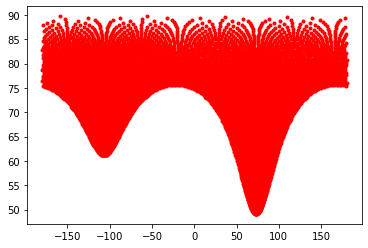

In [16]:
plt.plot(lons[-30:],lats[-30:],'r.');

In [17]:
def deseam(lon, lat, data):
    """
    Function to get rid of the "seam" that shows up on 
    the map when you're using these curvilinear grids.
    """
    i, j = lat.shape
    new_lon = np.zeros((i, j + 1))
    new_lon[:, :-1] = lon
    new_lon[:, -1] = lon[:, 0]

    new_lat = np.zeros((i, j + 1))
    new_lat[:, :-1] = lat
    new_lat[:, -1] = lat[:, 0]

    new_data = np.zeros((i, j + 1))
    new_data[:, :-1] = data
    new_data[:, -1] = data[:, 0]
    new_data = np.ma.array(new_data, mask=np.isnan(new_data))
    return new_lon, new_lat, new_data

In [18]:
lons, lats, newdata = deseam(lons,lats,data[0,:,:])

### Create Animation

In [20]:
# timestep
time_step = 120
years = [0,1*time_step, 2*time_step, 3*time_step, 4*time_step, 5*time_step, 6*time_step, 7*time_step, 8*time_step]

every_ten_years = dset_mohc_sithick['sithick'][years,:,:]
every_ten_years_time = dset_mohc_sithick['time'][years]

<IPython.core.display.Javascript object>


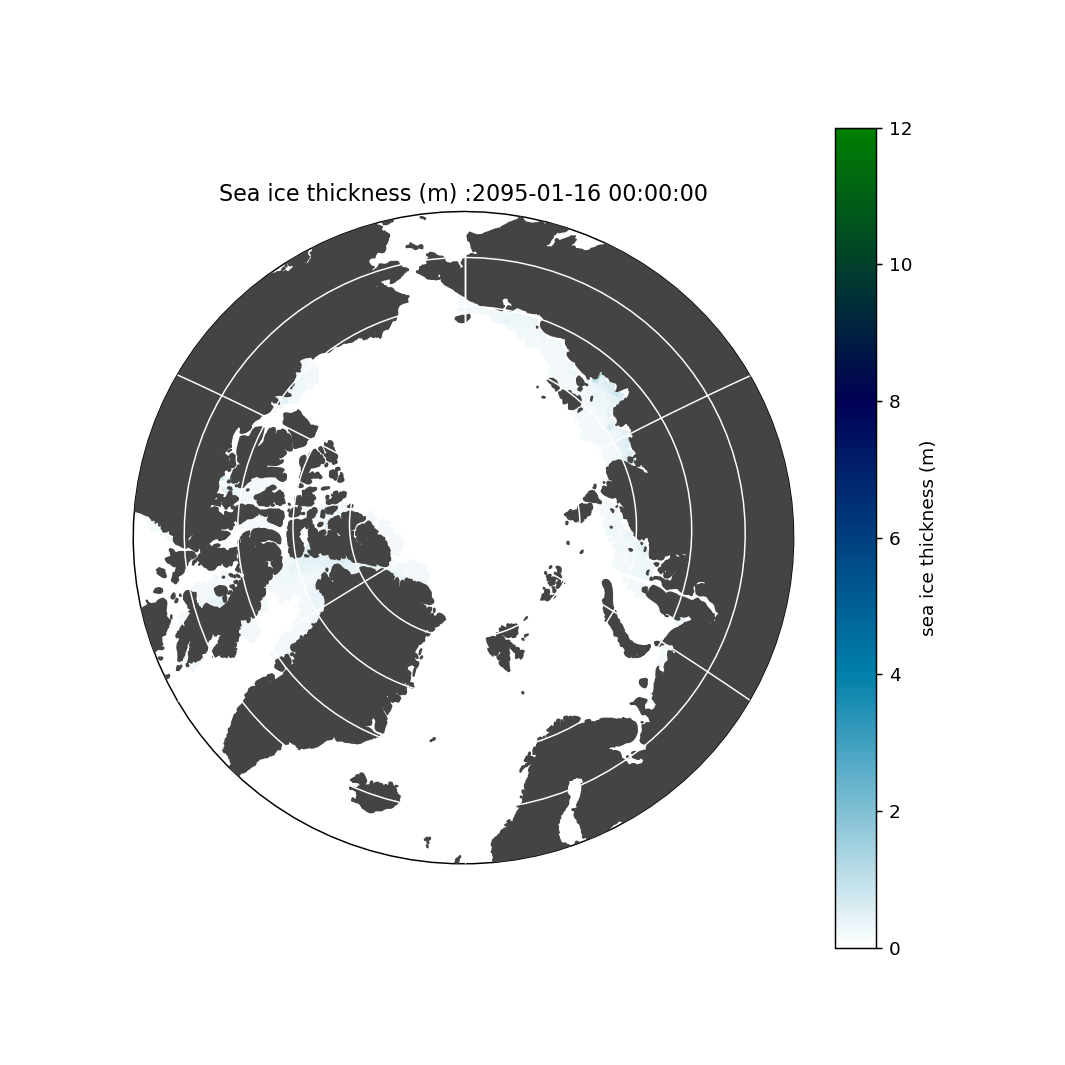

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


In [22]:
%matplotlib notebook

f, ax = plt.subplots(1,1,figsize=(6,6),
                     subplot_kw=dict(projection=ccrs.Orthographic(0, 80)))

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
cax = ax.pcolormesh(lons,
              lats,
              every_ten_years[0,:,:],
              transform=ccrs.PlateCarree(),
              vmin=0, vmax=12, cmap='ocean_r')

f.colorbar(cax, label='sea ice thickness (m)')

t = animation_data.time


#ax.set_title('CCCma sea ice thickness (m)' + str(dset_cccma_sithick['time'][i]))

# Add land.
ax.add_feature(cfeature.LAND, color='#444444', zorder=4);
ax.gridlines(color = "white", zorder=5)

def animate(i):
        cax.set_array(every_ten_years[i, :, :].values.flatten())
        ax.set_title('Sea ice thickness (m) :' + str(every_ten_years_time[i].values))
        

        
        
anim = animation.FuncAnimation(f, animate, interval=50, frames=len(t)-1, repeat=False, blit=True)

f.show()
animation_type = 'pcolor'
#anim.save('blue_hadgemLL_future8.5_ice.gif')